In [1]:
import uproot
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.compute as pc
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from multiprocessing import Pool
from functools import partial
import json
import os
from source import *
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True


In [3]:
dataset = ds.dataset("Gen_MC/merged.parquet", format="parquet")

In [ ]:
scanner = dataset.scanner(batch_size=100_000)
for batch in scanner.to_batches():
    table = pa.Table.from_batches([batch])
    print(table.to_pandas())
    break

        missedE        M0        p0      recM2  N_KL  idec0  idec1  \
0      4.585431  5.253232  0.540527  19.971792     0      2    2.0   
1      4.313035  5.253232  0.540527  17.636160     0      3    2.0   
2      4.288781  5.253232  0.540527  17.438116     0      3    2.0   
3      4.417442  5.253232  0.540527  18.515991     0      5    2.0   
4      4.544226  5.253232  0.540527  19.624304     0      5    2.0   
...         ...       ...       ...        ...   ...    ...    ...   
65531  1.884057  5.471964  0.551528   3.180567     1      4    3.0   
65532  1.574392  5.471964  0.551528   1.706872     1      4    3.0   
65533  1.303240  5.471964  0.551528   0.566099     1      4    3.0   
65534  2.151967  5.471964  0.551528   4.004136     1      2    4.0   
65535  1.848825  5.471964  0.551528   2.873450     1      3    4.0   

       totalEnergyMC  E_gamma_in_ROE    Bs_lik  is0  __experiment__  __run__  \
0          11.807576        2.200981  0.000105  NaN              43     1013   

In [3]:
decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]
decay_mode_to_nu = {
    0: 2,  # e+ nu_e nu_tau
    1: 2,  # mu+ nu_mu nu_tau
    2: 1,  # pi+ nu_tau
    3: 1,  # rho+ (pi+ pi0) nu_tau
    4: 1,  # pi+ pi+ pi- nu_tau
    5: 1
}
decay_mode_to_gamma = {
    0: 0,  # e+ nu_e nu_tau
    1: 0,  # mu+ nu_mu nu_tau
    2: 0,  # pi+ nu_tau
    3: 0,  # rho+ (pi+ pi0) nu_tau
    4: 0,  # pi+ pi+ pi- nu_tau
    5: 1
}

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_5340/818812396.py:1: SyntaxWarning: invalid escape sequence '\m'
  decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]


In [44]:
mask = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("is0") == 1) & (pc.field("Bs_lik") > 0.0012) &  (pc.field("M0") > 5.347) &  (pc.field("M0") > 5.387) 
mask0 = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("is0") == 0) & (pc.field("Bs_lik") > 0.0012) &  (pc.field("M0") > 5.347) &  (pc.field("M0") > 5.387)

In [8]:
mask_is1 = pc.field("correct_nu_0") & pc.field("correct_nu_0") & pc.field("correct_gamma_0") & pc.field("correct_nu_1") & pc.field("correct_nu_1") & pc.field("correct_gamma_1")

In [6]:
wbin = 0.2
a = 0
b = 5
bins = np.linspace(a, b, int((b-a)/wbin))


In [7]:
def compute_histogram(dataset, bins, tartget, filter_mask=None):
    scanner = dataset.scanner(batch_size=100_000, filter=filter_mask)
    hist_counts = np.zeros(len(bins) - 1)
    total_events = 0

    for batch in scanner.to_batches():
        table = pa.Table.from_batches([batch])
        dt = table[tartget].to_numpy()
        counts, _ = np.histogram(dt, bins=bins)
        hist_counts += counts
        total_events += len(dt)

    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    return bin_centers, hist_counts, total_events


/tmp/ipykernel_294316/681937437.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


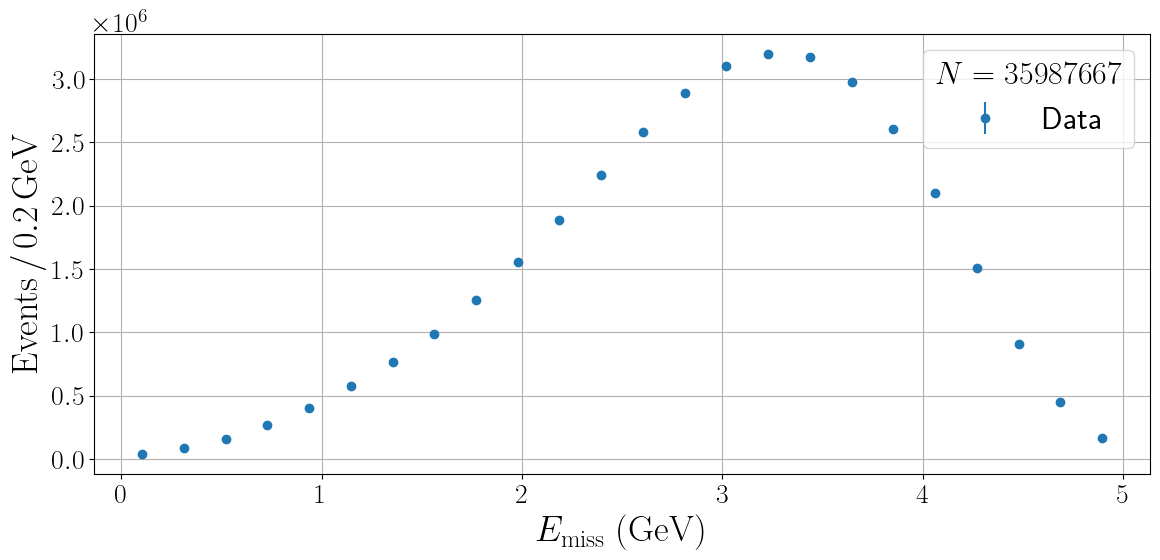

In [8]:
bin_centers, counts, N = compute_histogram(dataset, bins, "missedE", filter_mask=(pc.field("E_gamma_in_ROE") < 1.2))


fig, ax = plt.subplots(1, figsize=(12, 6))

ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Data")

ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
ax.set_xlabel(r'$E_\mathrm{miss} \; (\mathrm{GeV})$')
ax.set_title("")
ax.legend(title=f"$N = {N}$")
ax.grid(True)

plt.tight_layout()
plt.show()

/tmp/ipykernel_294316/2719730269.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


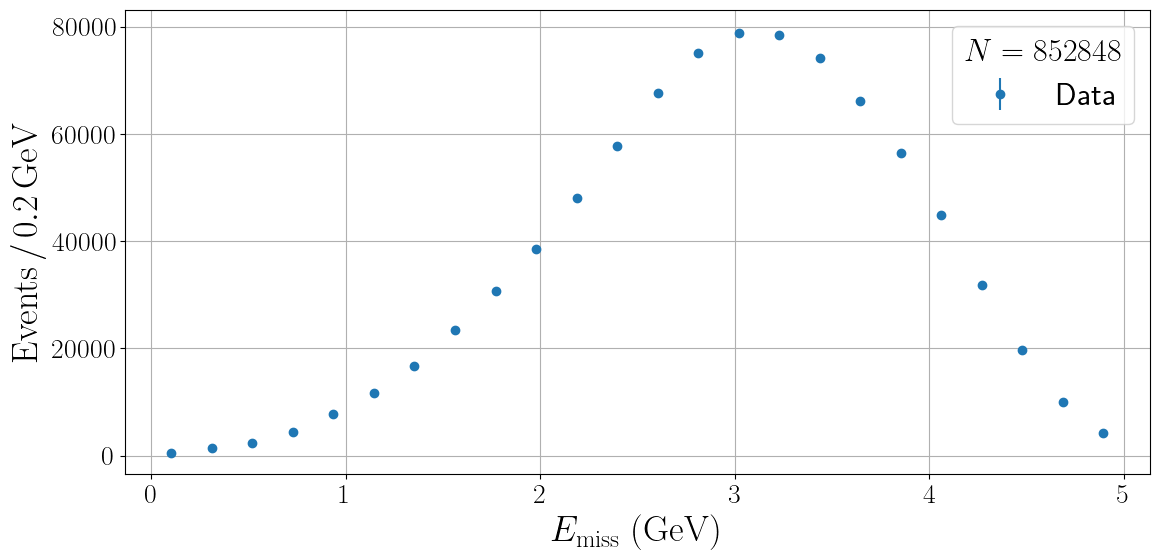

In [9]:
bin_centers, counts, N = compute_histogram(dataset, bins, "missedE", filter_mask=mask)


fig, ax = plt.subplots(1, figsize=(12, 6))

ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Data")

ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
ax.set_xlabel(r'$E_\mathrm{miss} \; (\mathrm{GeV})$')
ax.set_title("")
ax.legend(title=f"$N = {N}$")
ax.grid(True)

plt.tight_layout()
plt.show()

/tmp/ipykernel_294316/562186870.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


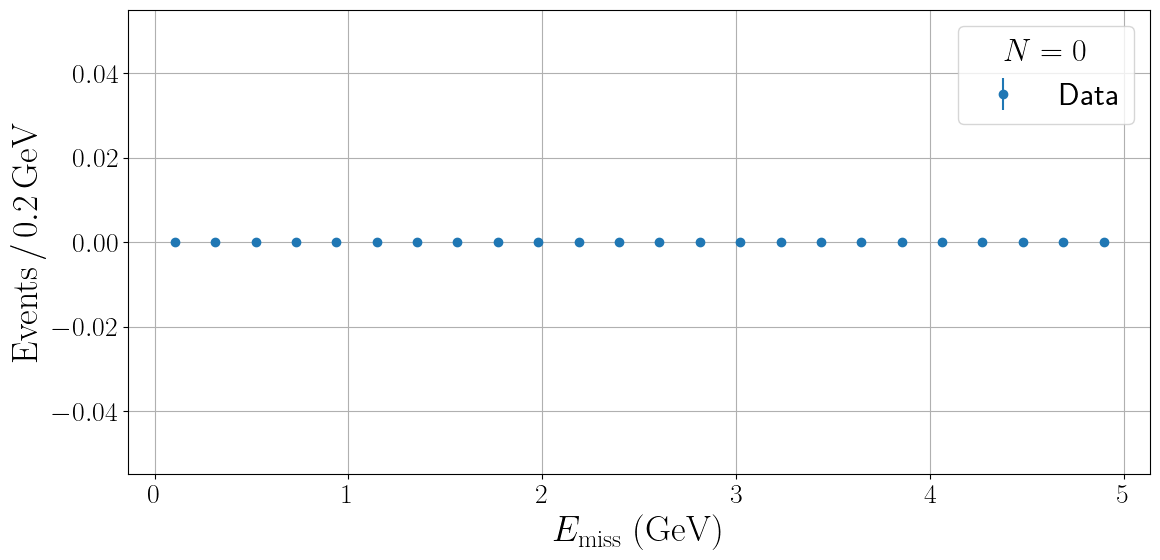

In [10]:
bin_centers, counts, N = compute_histogram(dataset, bins, "missedE", filter_mask=mask & mask_is1)


fig, ax = plt.subplots(1, figsize=(12, 6))

ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Data")

ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
ax.set_xlabel(r'$E_\mathrm{miss} \; (\mathrm{GeV})$')
ax.set_title("")
ax.legend(title=f"$N = {N}$")
ax.grid(True)

plt.tight_layout()
plt.show()



In [10]:
wbin = 0.05
a = 0
b = 1.2
bins = np.linspace(a, b, int((b-a)/wbin))


/tmp/ipykernel_294316/2004009764.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


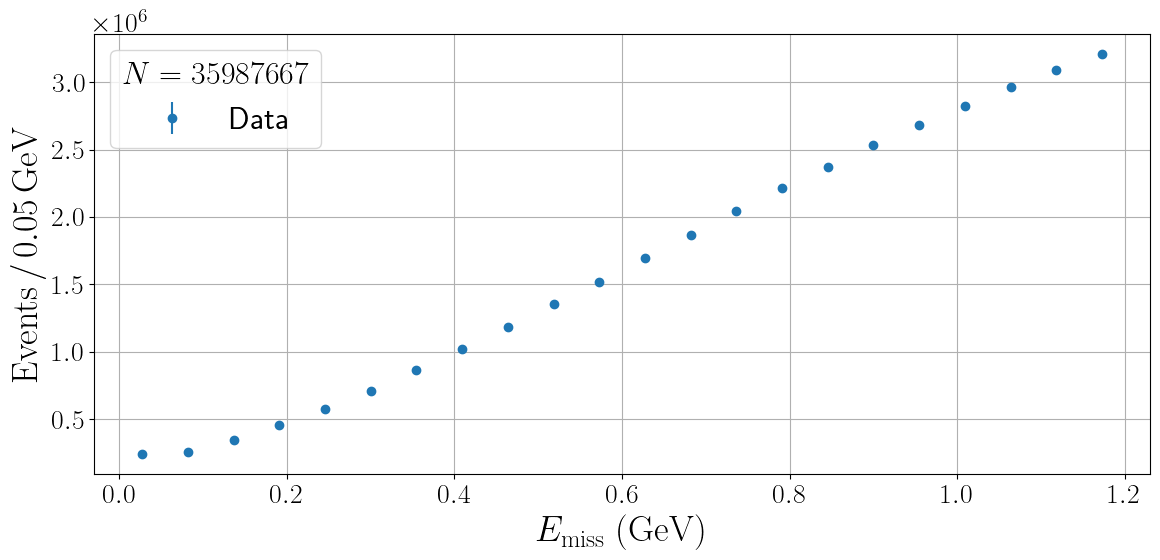

In [12]:
bin_centers, counts, N = compute_histogram(dataset, bins, "E_gamma_in_ROE", filter_mask=(pc.field("E_gamma_in_ROE") < 1.2))


fig, ax = plt.subplots(1, figsize=(12, 6))

ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Data")

ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
ax.set_xlabel(r'$E_\mathrm{miss} \; (\mathrm{GeV})$')
ax.set_title("")
ax.legend(title=f"$N = {N}$")
ax.grid(True)

plt.tight_layout()
plt.show()

/tmp/ipykernel_294316/4058006447.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


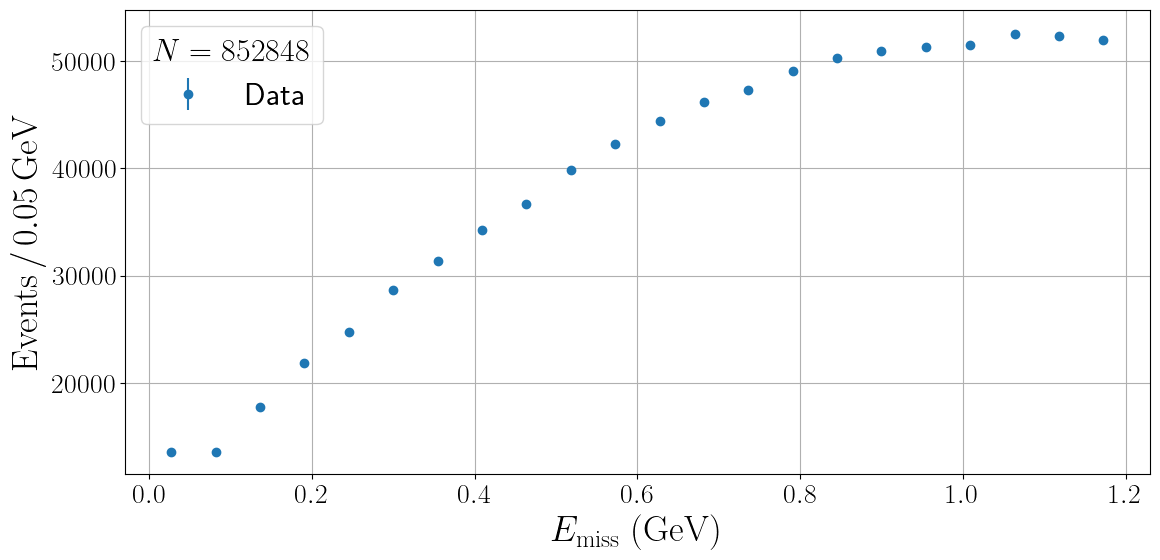

In [13]:
bin_centers, counts, N = compute_histogram(dataset, bins, "E_gamma_in_ROE", filter_mask=mask)


fig, ax = plt.subplots(1, figsize=(12, 6))

ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Data")

ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
ax.set_xlabel(r'$E_\mathrm{miss} \; (\mathrm{GeV})$')
ax.set_title("")
ax.legend(title=f"$N = {N}$")
ax.grid(True)

plt.tight_layout()
plt.show()

In [45]:
wbin = 0.05
a = 0
b = 1.2
bins = np.linspace(a, b, int((b-a)/wbin))
bin_centers = 0.5 * (bins[:-1] + bins[1:])

In [53]:
batches = list(dataset.scanner(batch_size=100_000, filter=mask).to_batches())

pairs = [(i, j) for i in range(5) for j in range(i + 1)]

def process_batch_for_all_pairs(batch, bins):
    table = pa.Table.from_batches([batch])
    with open('output/E_miss_bord.json', 'r') as openfile:
        json_object = json.load(openfile)
    # Преобразуем всё в NumPy
    missedE = table["missedE"].to_numpy()
    idec0 = table["idec0"].to_numpy()
    idec1 = table["idec1"].to_numpy()
    E_gamma = table["E_gamma_in_ROE"].to_numpy()
    histograms = {(i, j): np.zeros(len(bins) - 1) for (i, j) in pairs}
    counts = {(i, j): 0 for (i, j) in pairs}
    for i, j in pairs:
        cond = (missedE > json_object[f"{i}{j}"][0]) & (missedE < json_object[f"{i}{j}"][1]) & (
            ((idec0 == i) & (idec1 == j)) |
            ((idec0 == j) & (idec1 == i))
        )
        if not np.any(cond):
            continue
        h, _ = np.histogram(E_gamma[cond], bins=bins)
        histograms[(i, j)] += h
        counts[(i, j)] += np.sum(h)
    return histograms, counts

with Pool(8) as pool:
    results = pool.starmap(partial(process_batch_for_all_pairs, bins=bins), [(batch,) for batch in batches])

# Инициализация суммарных массивов
final_hist = {(i, j): np.zeros(len(bins) - 1)  for (i, j) in pairs}
final_counts = {(i, j): 0 for (i, j) in pairs}

# Суммируем по чанкам
for hist, count in results:
    for key in pairs:
        final_hist[key] += hist[key]
        final_counts[key] += count[key]

/tmp/ipykernel_5340/763634233.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


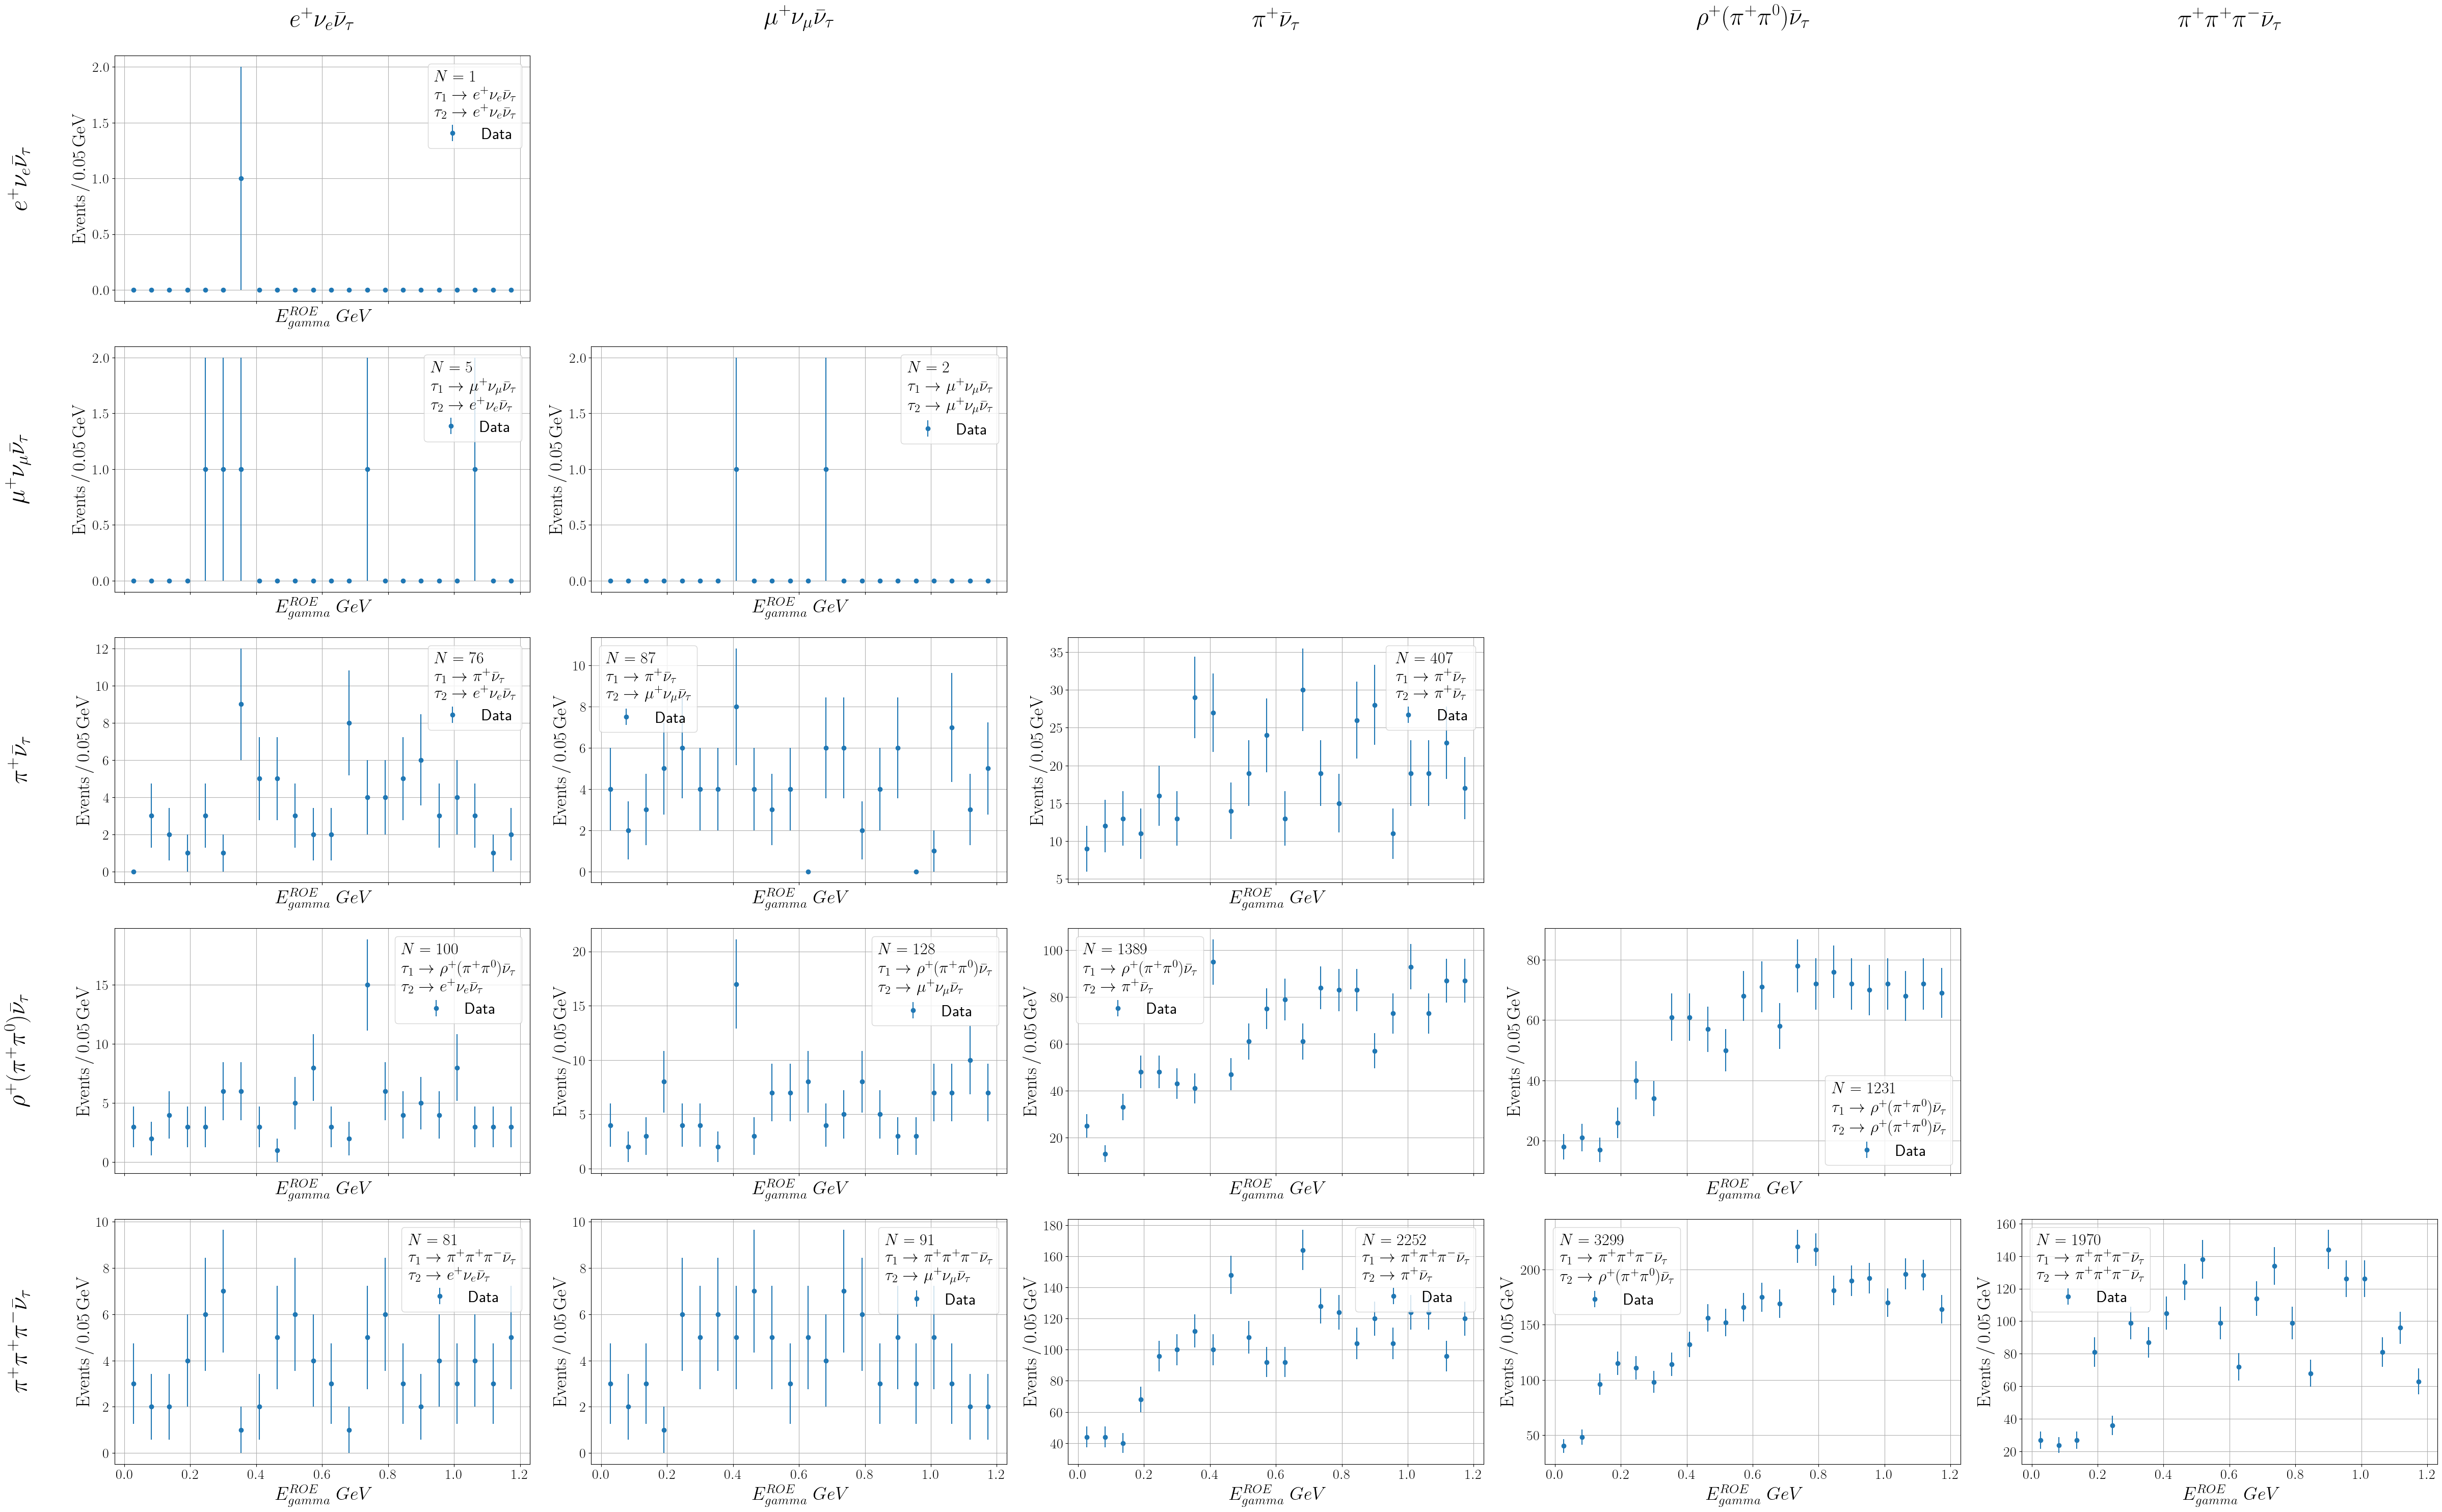

In [54]:
fig, axs = plt.subplots(5, 5, figsize=(10*1.6*3, 10*3), sharex=True)

for i in range(5):
    for j in range(5):
        ax = axs[i, j]
        if j > i:
            ax.axis("off")
            continue
        h = final_hist[(i, j)]
        N = final_counts[(i, j)]
        ax.errorbar(bin_centers, h, yerr=np.sqrt(h), fmt='o', label="Data")
        ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
        ax.set_xlabel(r'$E_{\\gamma}^{ROE} \ GeV$')
        ax.legend(
            title=f"$N = {N}$\n"
                  f"$\\tau_1 \\to$ {decay_mod_tau[i]}\n"
                  f"$\\tau_2 \\to$ {decay_mod_tau[j]}"
        )
        ax.grid(True)

for ax, row in zip(axs[:,0], decay_mod_tau):
    ax.annotate(row, xy=(-0.2, 0.5), xycoords='axes fraction',
                ha='right', va='center', fontsize=35, rotation=90, fontweight='bold')

for ax, col in zip(axs[0], decay_mod_tau):
    ax.annotate(col, xy=(0.5, 1.1), xycoords='axes fraction',
                ha='center', va='bottom', fontsize=35, fontweight='bold')

plt.tight_layout()
plt.savefig("output/E_gamma_is.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [48]:
from matplotlib.backends.backend_pdf import PdfPages

decay_mode_to_nu = {
    0: 2,
    1: 2,
    2: 1,
    3: 1,
    4: 1,
}

grouped_pairs = {4: [], 3: [], 2: []}

for i in range(5):
    for j in range(i + 1):
        total_nu = decay_mode_to_nu[i] + decay_mode_to_nu[j]
        grouped_pairs[total_nu].append((i, j))

for nu_sum, pairs in grouped_pairs.items():
    with PdfPages(f"output/E_gamma_is_{nu_sum}nu.pdf") as pdf:
        for i, j in pairs:
            fig, ax = plt.subplots(figsize=(12 * 0.9, 10 * 0.9))
            h = final_hist.get((i, j), np.zeros_like(bin_centers))
            N = final_counts.get((i, j), 0)

            # Расчёт среднего и сигмы

            ax.errorbar(bin_centers, h, yerr=np.sqrt(h), fmt='o', label="Data")

            ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
            ax.set_xlabel(r'$E_{{\gamma}}^{{ROE}} \ \mathrm{{GeV}}$')
            ax.legend(
                title=f"$N = {N}$\n"
                      f"$\\tau_1 \\to$ {decay_mod_tau[i]}\n"
                      f"$\\tau_2 \\to$ {decay_mod_tau[j]}"
            )
            ax.grid(True)
            fig.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)


/tmp/ipykernel_5340/2652231514.py:37: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_5340/2652231514.py:37: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


In [49]:
batches = list(dataset.scanner(batch_size=100_000, filter = mask0).to_batches())

pairs = [(i, j) for i in range(5) for j in range(i + 1)]

def process_batch_for_all_pairs(batch, bins):
    table = pa.Table.from_batches([batch])
    with open('output/E_miss_bord.json', 'r') as openfile:
        json_object = json.load(openfile)
    # Преобразуем всё в NumPy
    missedE = table["missedE"].to_numpy()
    idec0 = table["idec0"].to_numpy()
    idec1 = table["idec1"].to_numpy()
    E_gamma = table["E_gamma_in_ROE"].to_numpy()
    histograms = {(i, j): np.zeros(len(bins) - 1) for (i, j) in pairs}
    counts = {(i, j): 0 for (i, j) in pairs}
    for i, j in pairs:
        cond = (missedE > json_object[f"{i}{j}"][0]) & (missedE < json_object[f"{i}{j}"][1]) & (
            ((idec0 == i) & (idec1 == j)) |
            ((idec0 == j) & (idec1 == i))
        )
        if not np.any(cond):
            continue
        h, _ = np.histogram(E_gamma[cond], bins=bins)
        histograms[(i, j)] += h
        counts[(i, j)] += np.sum(h)
    return histograms, counts

with Pool(8) as pool:
    results = pool.starmap(partial(process_batch_for_all_pairs, bins=bins), [(batch,) for batch in batches])

# Инициализация суммарных массивов
final_hist = {(i, j): np.zeros(len(bins) - 1)  for (i, j) in pairs}
final_counts = {(i, j): 0 for (i, j) in pairs}

# Суммируем по чанкам
for hist, count in results:
    for key in pairs:
        final_hist[key] += hist[key]
        final_counts[key] += count[key]

/tmp/ipykernel_5340/2775744687.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


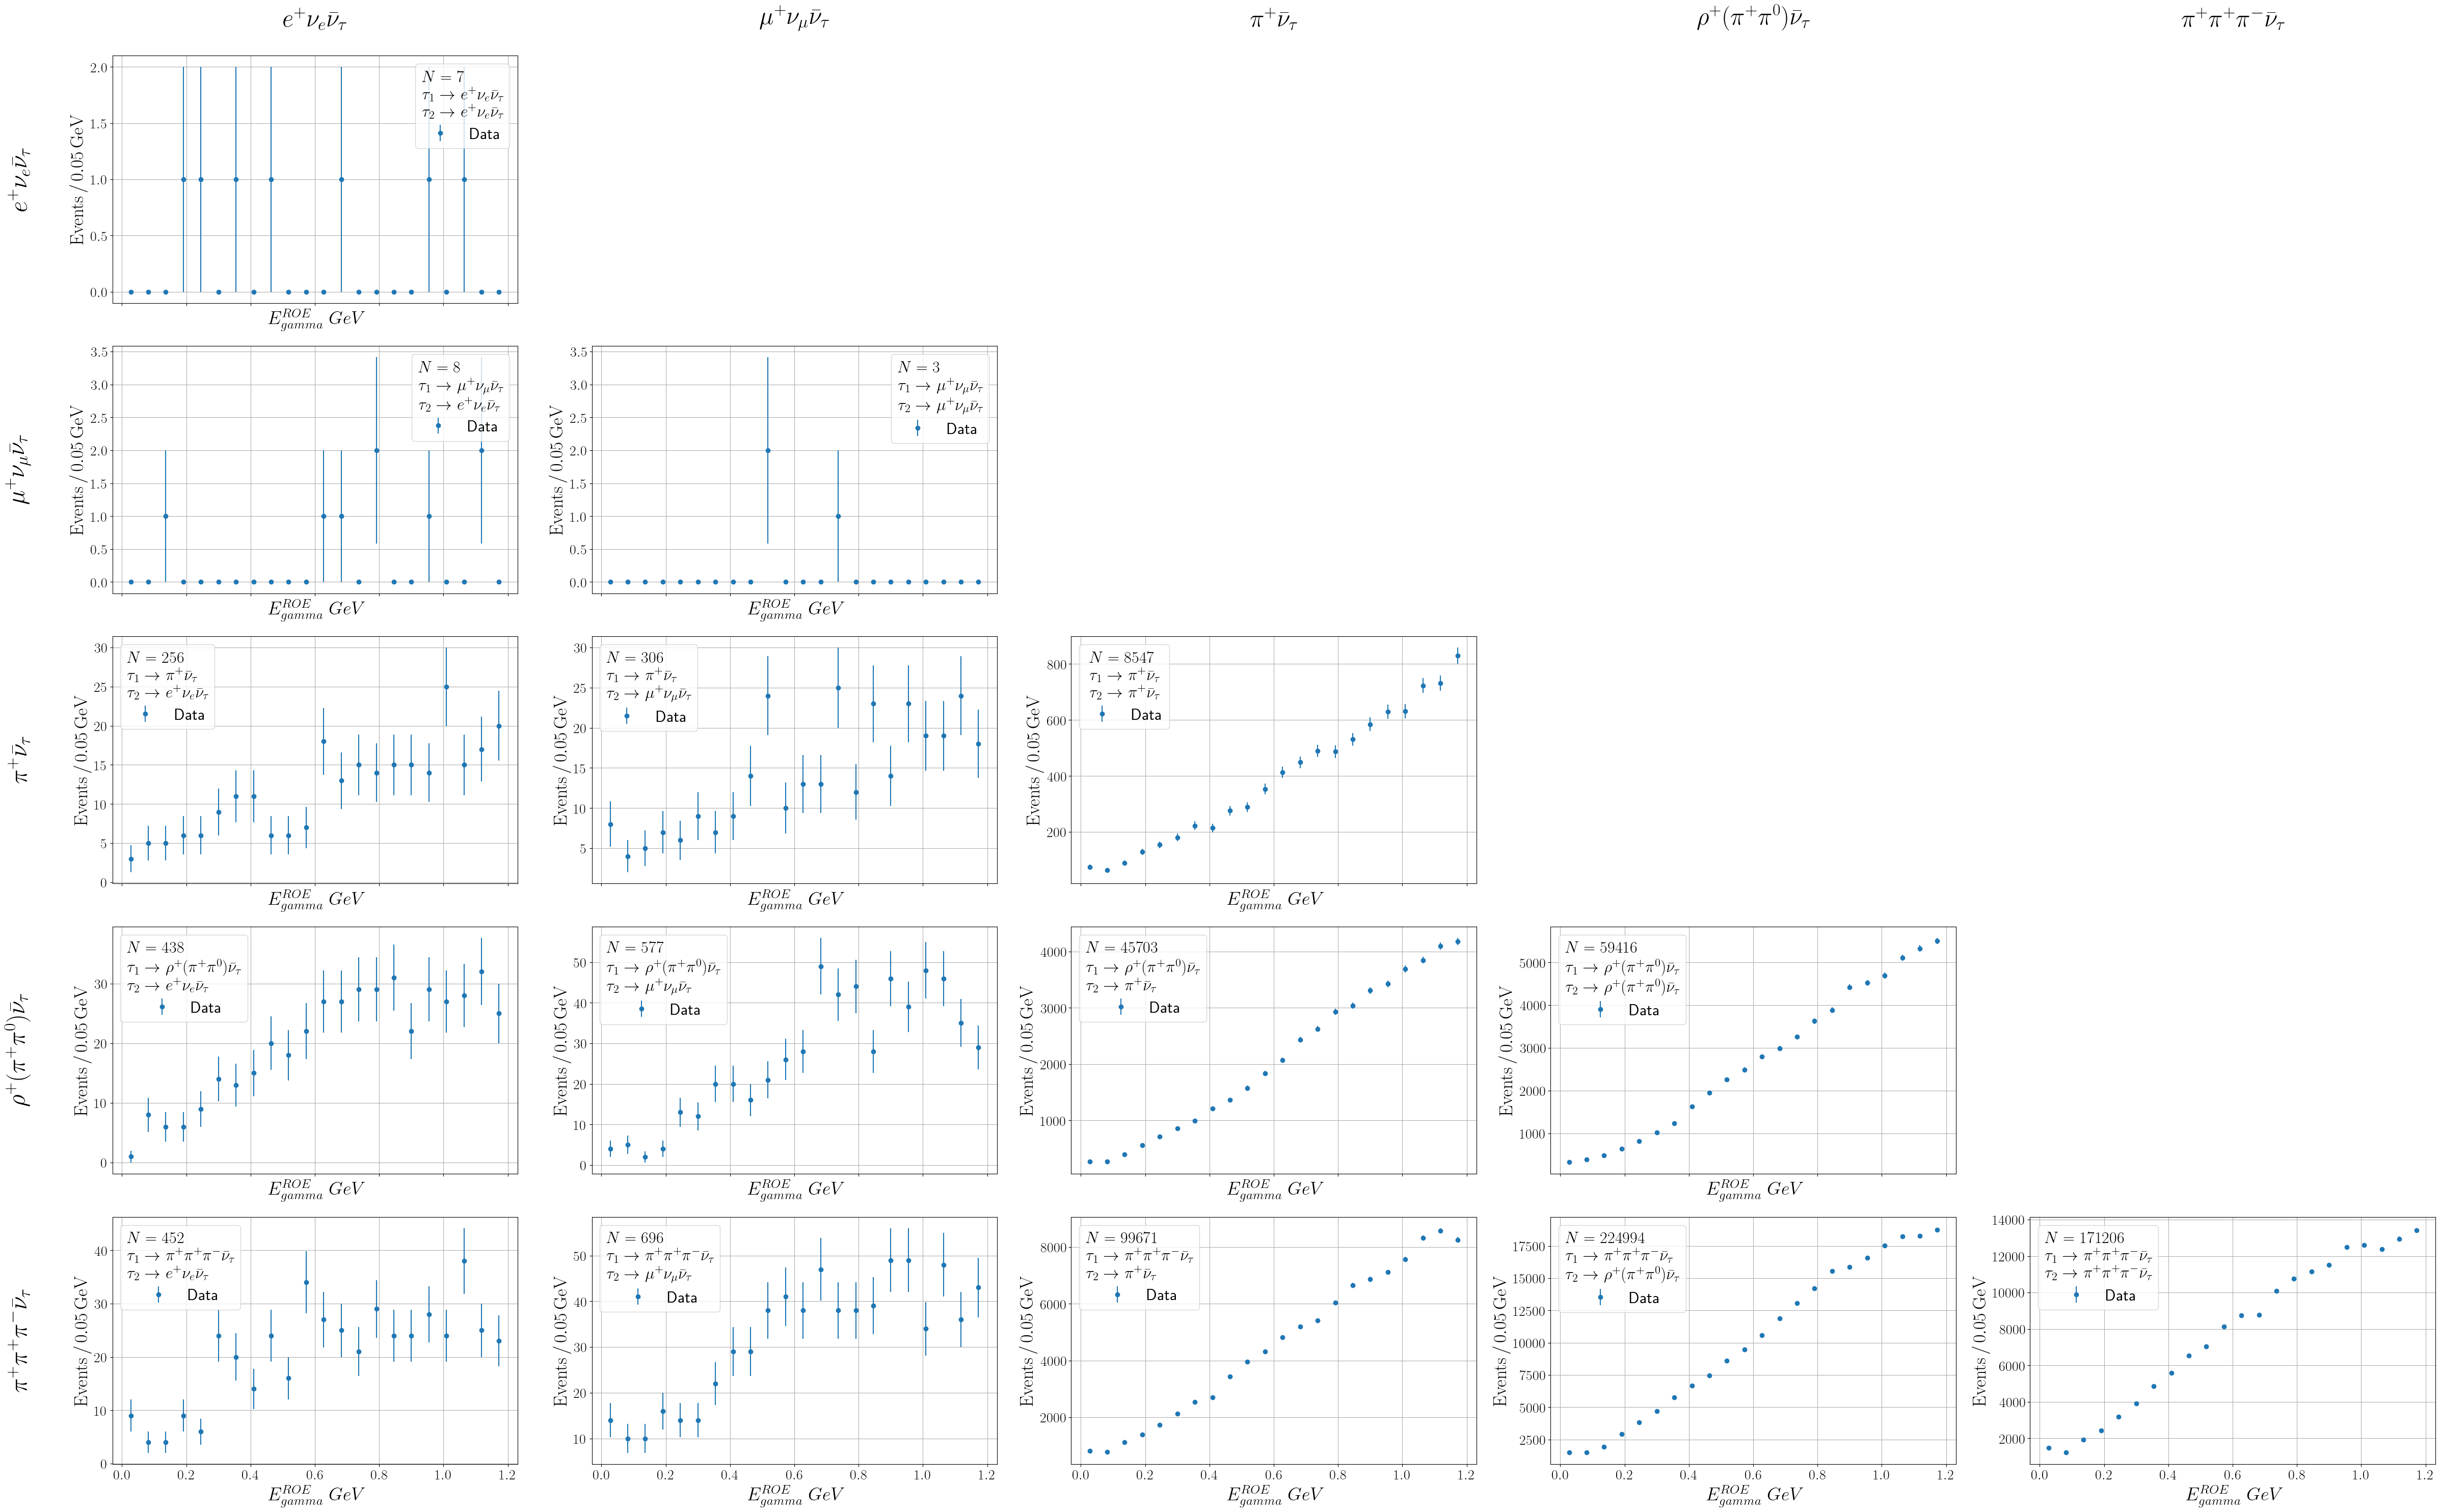

In [50]:
fig, axs = plt.subplots(5, 5, figsize=(10*1.6*3, 10*3), sharex=True)

for i in range(5):
    for j in range(5):
        ax = axs[i, j]
        if j > i:
            ax.axis("off")
            continue
        h = final_hist[(i, j)]
        N = final_counts[(i, j)]
        ax.errorbar(bin_centers, h, yerr=np.sqrt(h), fmt='o', label="Data")
        ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
        ax.set_xlabel(r'$E_{\\gamma}^{ROE} \ GeV$')
        ax.legend(
            title=f"$N = {N}$\n"
                  f"$\\tau_1 \\to$ {decay_mod_tau[i]}\n"
                  f"$\\tau_2 \\to$ {decay_mod_tau[j]}"
        )
        ax.grid(True)

for ax, row in zip(axs[:,0], decay_mod_tau):
    ax.annotate(row, xy=(-0.2, 0.5), xycoords='axes fraction',
                ha='right', va='center', fontsize=35, rotation=90, fontweight='bold')

for ax, col in zip(axs[0], decay_mod_tau):
    ax.annotate(col, xy=(0.5, 1.1), xycoords='axes fraction',
                ha='center', va='bottom', fontsize=35, fontweight='bold')

plt.tight_layout()
plt.savefig("output/E_miss_tau_chan_s1_1.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [51]:
from matplotlib.backends.backend_pdf import PdfPages

decay_mode_to_nu = {
    0: 2,
    1: 2,
    2: 1,
    3: 1,
    4: 1,
}

grouped_pairs = {4: [], 3: [], 2: []}

for i in range(5):
    for j in range(i + 1):
        total_nu = decay_mode_to_nu[i] + decay_mode_to_nu[j]
        grouped_pairs[total_nu].append((i, j))

for nu_sum, pairs in grouped_pairs.items():
    with PdfPages(f"output/E_gamma_not_{nu_sum}nu.pdf") as pdf:
        for i, j in pairs:
            fig, ax = plt.subplots(figsize=(12 * 0.9, 10 * 0.9))
            h = final_hist.get((i, j), np.zeros_like(bin_centers))
            N = final_counts.get((i, j), 0)

            # Расчёт среднего и сигмы

            ax.errorbar(bin_centers, h, yerr=np.sqrt(h), fmt='o', label="Data")

            ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
            ax.set_xlabel(r'$E_{{\gamma}}^{{ROE}} \ \mathrm{{GeV}}$')
            ax.legend(
                title=f"$N = {N}$\n"
                      f"$\\tau_1 \\to$ {decay_mod_tau[i]}\n"
                      f"$\\tau_2 \\to$ {decay_mod_tau[j]}"
            )
            ax.grid(True)
            fig.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)


/tmp/ipykernel_5340/2060203869.py:37: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_5340/2060203869.py:37: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
